In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

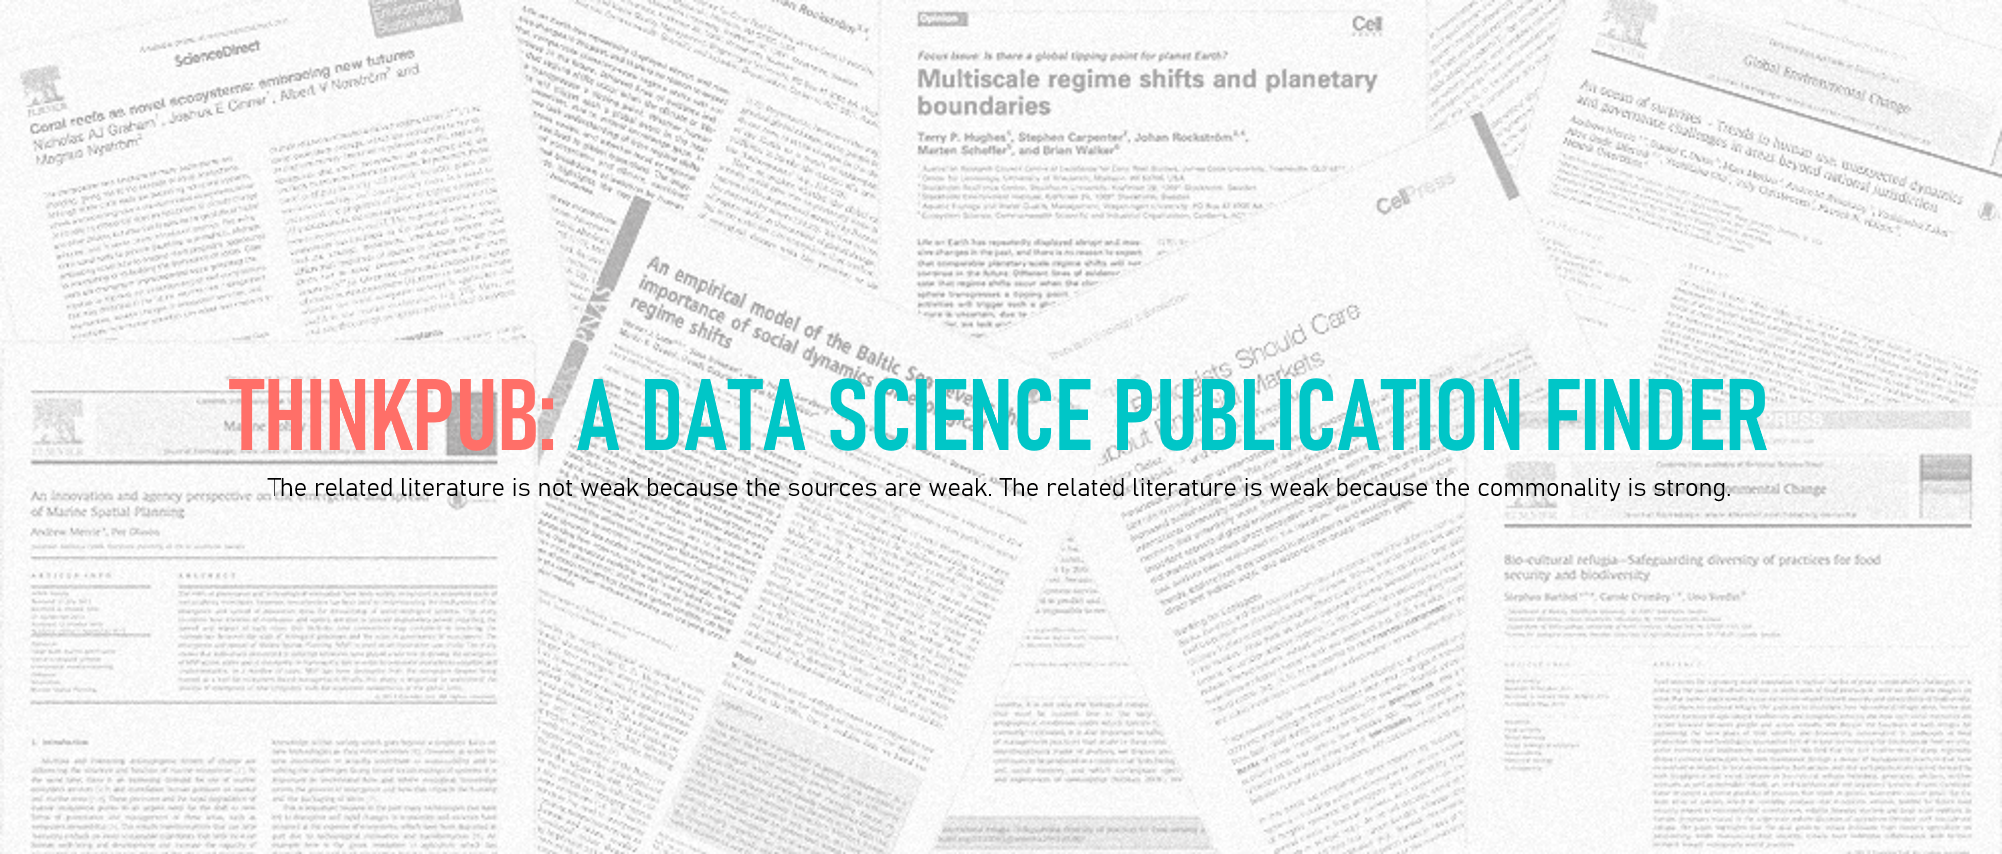

<font size=5><strong><center>A Recommender Engine for Data Science Publications</center></strong></font>

## Executive Summary

This project aims to build a recommender system based on the journals and books extracted from the Springer API Metadata. Data extracted from the Springer API are documents relevant only to `Data Science` keyword. Post extraction, we load the data into SQL and vectorized a smaller sample of the keywords using sklearn libraries. After then, we scored the sample using cosine similarity, returning the best matches first. We have performed standard exploratory data analysis with all data loaded. The final output allows query on `title` and `creator` columns on top of the `abstract` column for which we have initially designed the algorithm for.

The output would be helpful for small scale internal document search projects. The code base that we have built can be applied to any text fields, and the table utilized can be from any table outside Springer API. As long as the data is loaded in the same format, we can utilize this for data from other APIs as well.

To note, results of the project are purely based on how high the cosine similarity is without understanding the semantics of the words being searched. With this, we have successfully completed the requirement we have proposed. Further improvements in performance can still be applied by storing the results of the vectorization to a file,  combining more fields for better search results (e.g. adding publication date), streaming data into the vectorization may be good in scaling up the project, and applying natural language processing techniques (NLP) to have semantic analyses in place.

## Data Description

The study uses the dataset from Springer API that provides metadata and full-text content for more than 14 million online documents from Springer Nature Open Access XML, including BMC and SpringerOpen journal. Records are details such as creator, publication, url, title, abstract, etc. from a book or journal relevant to the search criteria used in the API. 

<br>
<center><i> Relevant variables from springer_dump table</i></center>

|<center>Variable Name</center>|<center>Data Type</center>| 
|:---|:---|
|`identifier`	|TEXT|
|`contentType`	|TEXT|
|`language`	|TEXT|
|`title`	|TEXT|
|`creators`	|TEXT|
|`publicationName`	|TEXT|
|`openaccess`	|TEXT|
|`publisher`	|TEXT|
|`publicationDate`	|TEXT|
|`publicationType`	|TEXT|
|`genre`	|TEXT|
|`copyright`	|TEXT|
|`abstract`	|TEXT|
|`startingPage`	|TEXT|
|`endingPage`	|TEXT|
|`journalId`	|TEXT|
|`subjects`	|TEXT|


### Data Assumptions and Limitations
We extracted the data using a keyword filter. For this project, we filtered using “Data Science” keyword only. We cannot give a definite guarantee on the actual relevance of the journals or books returned as the API has no classifying tags within its data sets that could have been used for a scoring system. Particularly for our main information retrieval output (i.e. the recommender engine), we will only be using a subset of the data to make sure that the team can work on Jojie server as not everyone has a local powerful machine. Vectorizing a huge corpus causes the kernel to die even at 30k to 40k records. With this, we limited our data set to 25k English records. The approach would also be purely from a numerical scoring perspective and not yet considering any semantics for words searched.

## Introduction

### Background

In this day and age, vast amount of information are generated rapidly as more and more things turn digital and online. Large volumes of structured and unstructured data are being generated, and this results in an overwhelming amount of information made available for every domain.[[4]](https://thesai.org/Downloads/Volume8No12/Paper_27-Recommender_System_for_Journal_Articles.pdf)

At a time when a lot of data is available, tools like recommender systems are very efficient for filtering information. A recommender system is a subclass of information retrieval, which is the process of obtaining information system resources relevant to an information need from a collection of those resources.[[2]](https://en.wikipedia.org/wiki/Recommender_system)[[1]](https://en.wikipedia.org/wiki/Information_retrieval)

In essence, recommender engines are systems designed to output recommendations for a user based on many different factors. Advanced recommender engines predict the most likely product that users might purchase or might be interested in. Companies like Netflix, Spotify, and Amazon, use recommender systems in suggesting movies, music, or products to their user base.[[3]](https://www.analyticssteps.com/blogs/what-are-recommendation-systems-machine-learning)  

One of the use cases of a recommender system is a publication recommender engine. With an increase in the publication of different research across domains, researchers or authors may find it difficult to look for relevant publications for their research work. Developing a recommendation system that can suggest suitable publications to these people will be very useful.[[4]](https://thesai.org/Downloads/Volume8No12/Paper_27-Recommender_System_for_Journal_Articles.pdf) 

For this project, we use data from Springer Nature API, which contains metadata and full-text content of journal articles, book chapters, etc. Springer Nature is the leading global scientific publisher of books and journals. Their Springer Nature metadata API provides information on 14 million online documents. We use a subset of their data (those that are Data Science related) to build our recommender engine project.


### Problem Statement

This project aims to create a system that will recommend journals based on titles, abstracts, and author names, ranked according to similarity.

## Data Mining & Wrangling Methodology

This study followed the methodology pipeline described in the figure below. The different tasks performed for each step in the methodology are described in detail in this section.

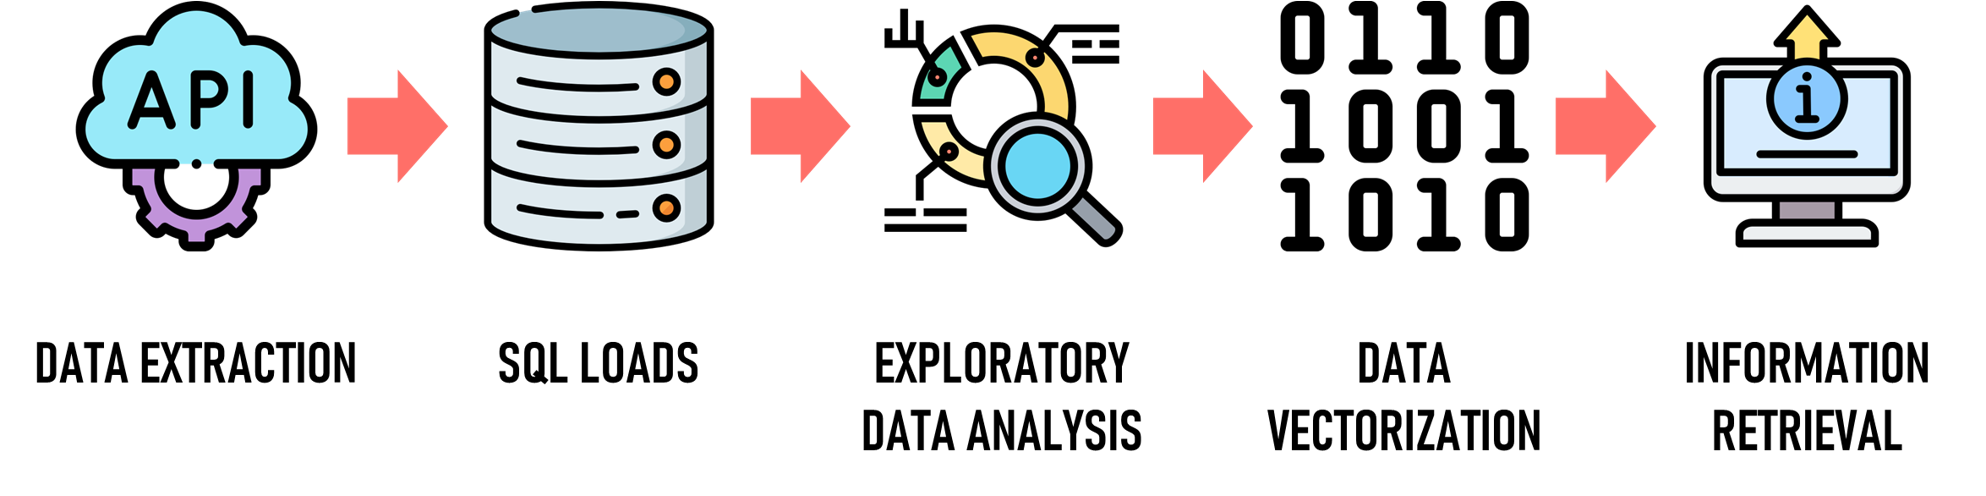

### Step 1: Extract data from Springer API using Python
We extracted data from the API using Python scripting. Here are the links to 
[API documentation](https://dev.springernature.com/docs) and [URL](https://api.springernature.com/metadata/json).

* Initial filter used: `q=Data Science`
* Filter: `q=keyword:Data Science`
* Type: `JSON`
* API call limit: `5k request/day`

We have done an initial load of 1M records using the initial filter. However, after investigation, the data is quite far from Data Science topics. We needed to fine-tune our query further and ended up using an additional filter `keyword:Data Science`. This allowed us to access the tags instead of relying on data relevance from the base search. We loaded 100k records on the second batch, and we used a parallel load strategy on multiple scripts. However, as mentioned in the Data Limitations, we will only be using a 25k subset of it.

### Step 2: SQL Loads
Our extracted API data in JSON format was loaded as a table in SQLite3 database `springer_data_science.db`. The table `springer_dump` has 34 columns. All columns were loaded into text though there are multi level JSON like `creators` column. Particular to the `creators` column, we inserted the data as a list of text and have later extracted it. As we have executed load using multiple scripts, we have consolidated the two set of loads we did before analyzing the data further.

### Step 3: Exploratory Data Analysis
After the data loads, we performed exploratory data analysis to understand how we can utilize the data further in our business case. Our EDA insights primarily focus on contextualizing the pool of recommendations for queried publications. Post EDA, we have found out that the data is clean and no post-processing is required. Hence, we utilized data as is.

### Step 4: Data Vectorization
We have done vectorization on 3 key fields for our recommender system. This will be the basis of our information retrieval. In our study, we have used two techniques to vectorize the data (discussed below). Set of stop words used is just the default english parameter within the libraries. We also did not limit the features as it can still run the full data at 25k records without any problem.

* `creator` – We have used sklearn’s CountVectorization to check similarity based on the exact count of each name in the creator column.
* `title`, `abstract` – We have used sklearn’s TfidfVectorizer to check the similarly based on the frequency of the words and how a certain word is rare across the documents.

Data is retrieved from SQL then we perform a transformation on the selected field, returning a sparse matrix stored in an object variable. We use this to retrieve information in our final step. For every run, we store data in an object to ensure we have the latest set of matching rows in the database.

The class object we have created is also able to vectorize any text fields as needed, but based on our analysis, these `title`, `abstract`, and `creator` are the three fields that make the most sense to query when people are looking for journals or books. 

### Step 5: Information Retrieval Similarity Search 
In the last step of our study, we performed an Information Retrieval based on the returned sparse matrix. We are using cosine similarity, and the returned similarity scores will be sorted from highest (1) to lowest (0). For TF-IDF, since the returned value of the matrix is already normalized, we only needed to perform `linear_kernel` function to complete the process and get the most relevant documents. The index +1 of the sparse matrix (converted to an array) will then be matched with the ROWID of the SQL database. For the different query fields (`title`, `abstract`, and `creator`), we return all matches starting from the most relevant.

## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import requests
import os
from os import path
import json
import ast
from datetime import datetime

import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
import functools
from IPython.display import clear_output

from tqdm.notebook import tqdm

In [3]:
# Connecting to a db in a masked file path
with open('filepath.txt') as f:
    filepath = f.readline().split('"')[1]

conn = sqlite3.connect(f'{filepath}/springer_data_science.db')

In [4]:
# Load the springer_dump table from the database
# Drop irrelevant columns
# Language filter based on declared language in the metadata

corpus = pd.read_sql('select * from springer_dump', conn)
corpus.set_index('identifier', inplace=True)
cols = ['eIssn','bookEditors','response','conferenceInfo','issn','onlineDate',
        'coverDate','isbn','doi','url', 'keyword', 'printIsbn','electronicIsbn'
       ,'volume', 'number','issueType','topicalCollection']

corpus = corpus.drop(cols, axis=1)
corpus = corpus[corpus['language'] == 'en']

### Contextualizing pool of publication recommendations

As the group was able to create a recommender system for publications using either the publication title, abstract, or creator as the query, this section contains EDA contextualizing pool of publication recommendations. This is done in order to evaluate our dataset and provide outline on its major attributes.

As shown in the graph below, we can see that Springer is not the only publisher that is loaded from its database although it has published almost 94 percent of its content.

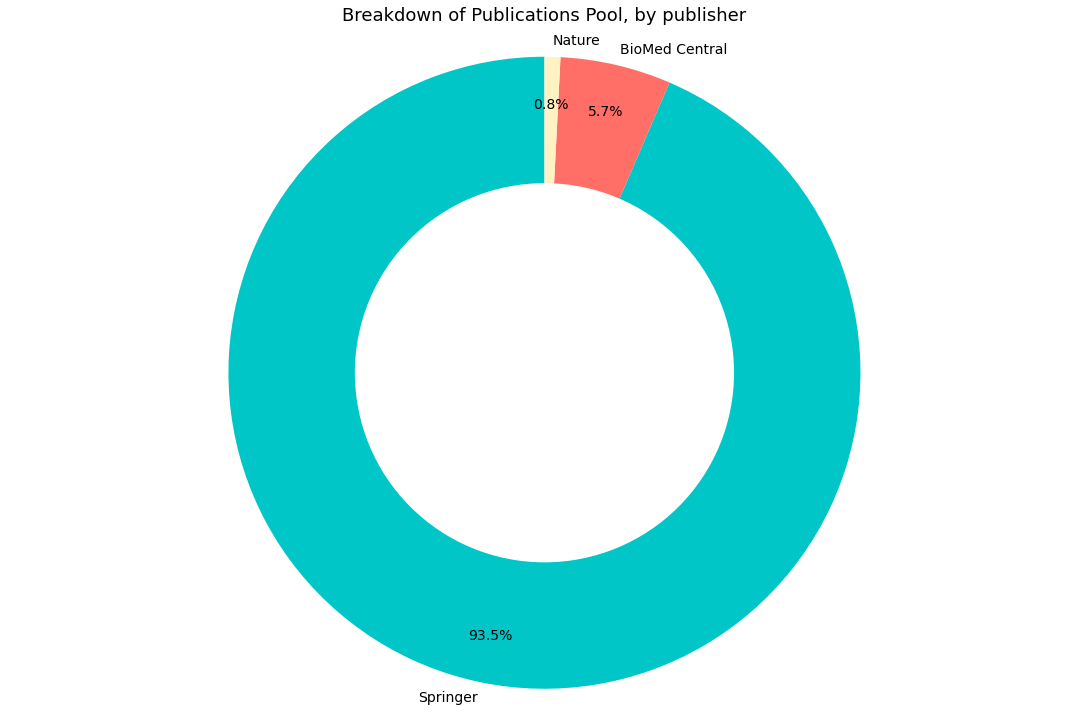

In [5]:
# To create a pie chart of the breakdown of publications by publisher name

publisher = corpus.publisher.value_counts()

plt.rcParams['font.size'] = 14.0
fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

colors = ['#00c6c7','#ff6f68','#fff2c3']
plt.pie(publisher, colors = colors, labels=publisher.index, autopct='%1.1f%%',
         startangle=90, pctdistance=0.85, labeldistance=1.05)

centre_circle = plt.Circle((0,0),0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')  
plt.title('Breakdown of Publications Pool, by publisher', fontsize=18)
plt.show()

For the dataset of Data-Science-related publications, Pophyrins has the most number of published articles along with Multimedia Tools and Applications, BMC Bioinformatics, Journal of Supercomputing, Cluster Computing, Neural Computing and Applications, Wireless Personal Communications, Soft Computing, Annals of Operations Research, and Knowledge and Information Systems. Even though BioMed Central has lower volume of publication pool compared to Springer, its publication name (BMC Bioinformatics) was able to make it to the top three (3) publication names.

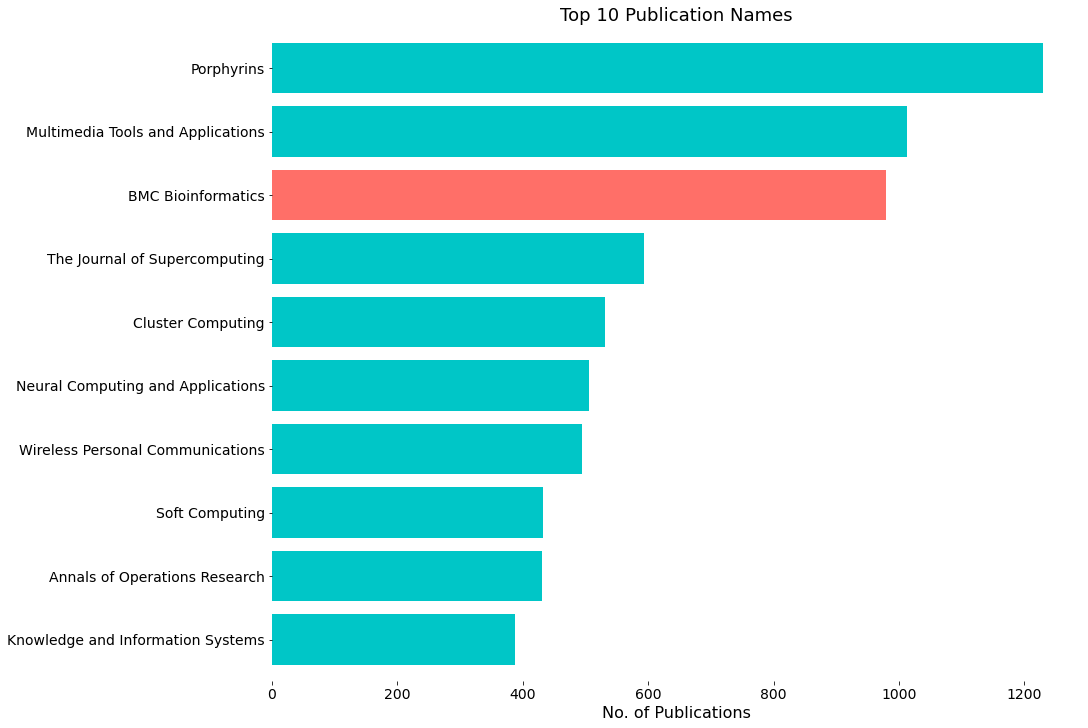

In [6]:
# To create a horizontal bar chart of the top 10 publication names in terms of volume of publications

pub = corpus.publicationName.value_counts().sort_values().tail(10)

fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

ax.set_facecolor("white")
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

pub.plot(kind='barh', color=['#00c6c7']*7+['#ff6f68']+['#00c6c7']*2, width=0.8)

plt.title('Top 10 Publication Names', fontsize=18)
plt.xlabel("No. of Publications", fontsize=16)

plt.show()

From the graph below, we see that the publication type is not limited to journal articles. In fact, more than half of the publication pool are books.

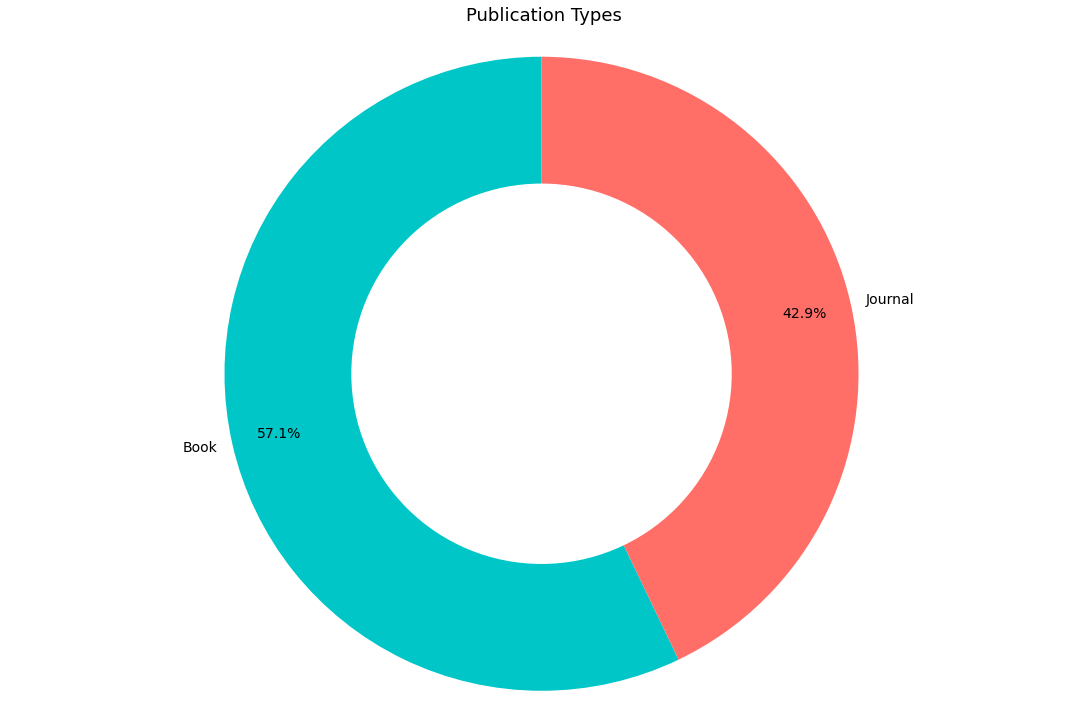

In [7]:
# To create a pie chart of the breakdown of publications by publication type - book or journal

pub_type = corpus.publicationType.value_counts()

plt.rcParams['font.size'] = 14.0
fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

colors = ['#00c6c7','#ff6f68']
plt.pie(pub_type, colors = colors, labels=pub_type.index, autopct='%1.1f%%',
         startangle=90, pctdistance=0.85, labeldistance=1.05)

centre_circle = plt.Circle((0,0),0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')  
plt.title('Publication Types', fontsize=18)
plt.show()

In terms of subject, most number of publications are tagged under Computer Science. Other common subject tags are Artificial Intelligence, Engineering, Computational Intelligence, Computer Communication Networks, Information Systems, Data Mining, Database Management, and Communications Engineering, Networks.

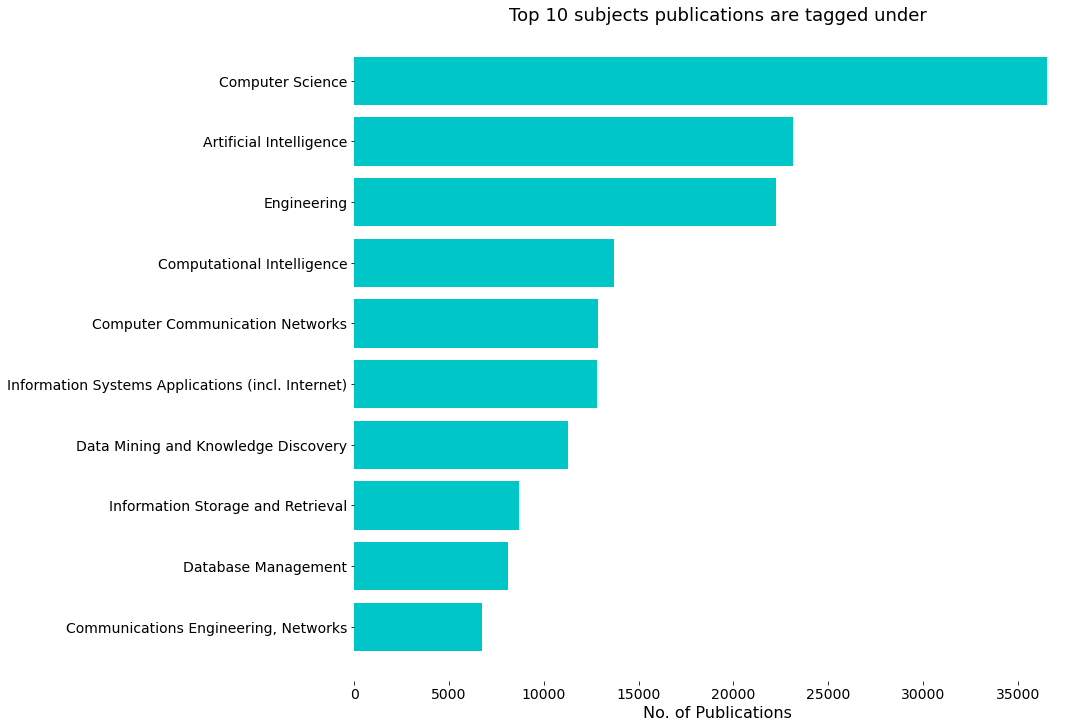

In [8]:
# To create a horizontal bar chart of the top 10 subjects that the publications are tagged under

subjects = list()

for i in corpus.subjects.fillna(''):
    try:
        subjects.extend(eval(i))
    except:
        subjects.append(i)

subjects = sorted(Counter(subjects).items(), key=lambda x: (x[1], x[0]))
ids = [x[0] for x in subjects[-10:]]
vals = [x[1] for x in subjects[-10:]]


fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

ax.set_facecolor("white")
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.barh(ids, vals, color='#00c6c7')

plt.title('Top 10 subjects publications are tagged under', fontsize=18)
plt.xlabel("No. of Publications", fontsize=16)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.show()

Searches for books, e-books and peer-reviewed journals published in Springer can further be refined by content type. For this dataset, the common content types are Article, Chapter ConferencePaper, Chapter, Chapter Reference Work Engry and Chapter Protocol. Articles in Springer are written work published for the purpose of propagating news, research results, academic analysis, or debate while conference papers are generally a short.

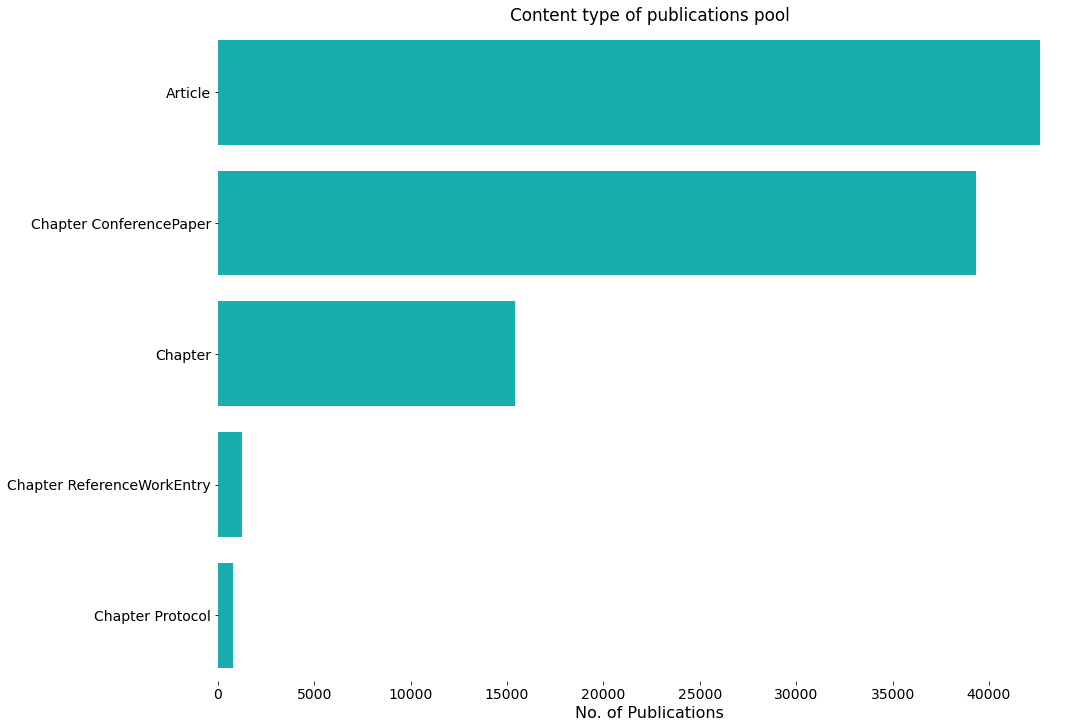

In [9]:
# To create a horizontal bar chart for the breakdown of publications by content type

content = corpus['contentType'].value_counts(ascending=False).reset_index()
content.rename(columns = {'index':'contentType', 'contentType':'count'}, inplace = True)

fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

ax.set_facecolor("white")
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

sns.barplot(data=content, x='count', y='contentType', color='#00c6c7').set(title='Content type of publications pool')

plt.ylabel('')
plt.xlabel("No. of Publications", fontsize=16)

plt.show()

Trend shows increasing volume of publications with copyrights being issued in the past decade. This could be an indication that more and more work are being done in the field.

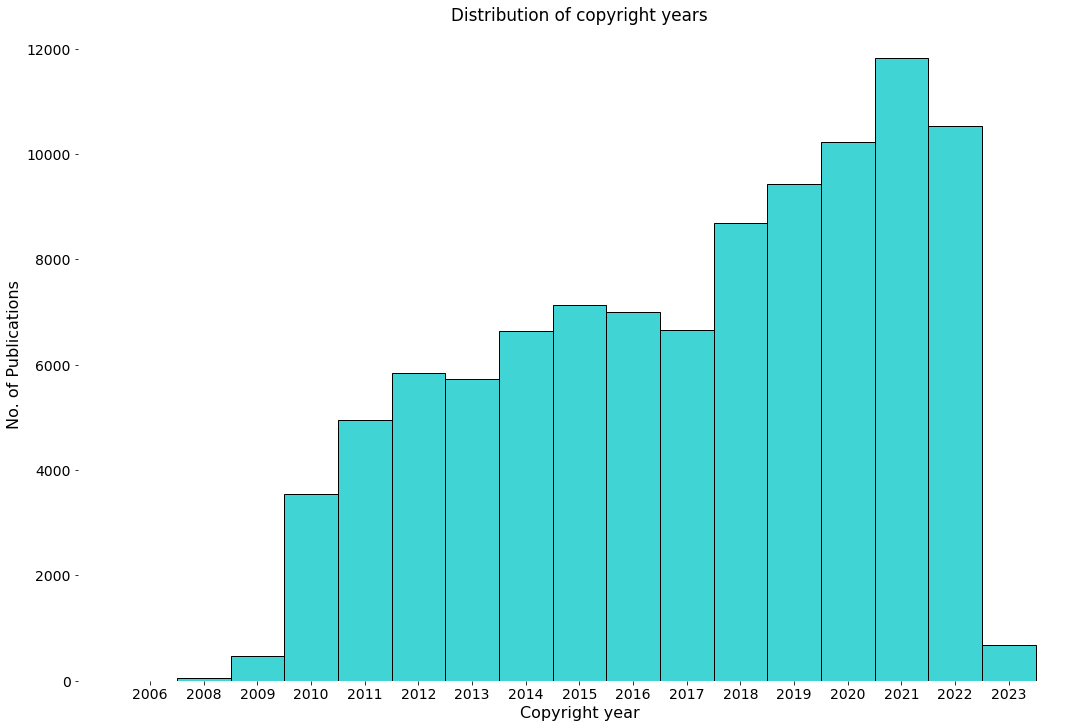

In [10]:
# To show distribution of copyright years within the dataset

book_articles = corpus["copyright"]
year = book_articles.str.extract(pat = '([0123456789]...)').sort_values(by=[0],ascending=True)
year = year.rename(columns={0: 'year'})

fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

ax.set_facecolor("white")
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

sns.histplot(data=year, x=year['year'], color='#00c6c7').set(title='Distribution of copyright years')

plt.xlabel("Copyright year", fontsize=16)
plt.ylabel("No. of Publications", fontsize=16)

plt.show()

### Inspecting the query fields for the publications recommender engine

#### Titles
This word cloud is composed of words used in Data Science-related publication titles within the dataset. The common words appearing based on frequency are the words 'Based', 'Using', 'Big Data', 'Analysis', 'Model', and 'Application'. This tells us that when picking titles, Data Science publications often highlights the model, analysis, or technique.

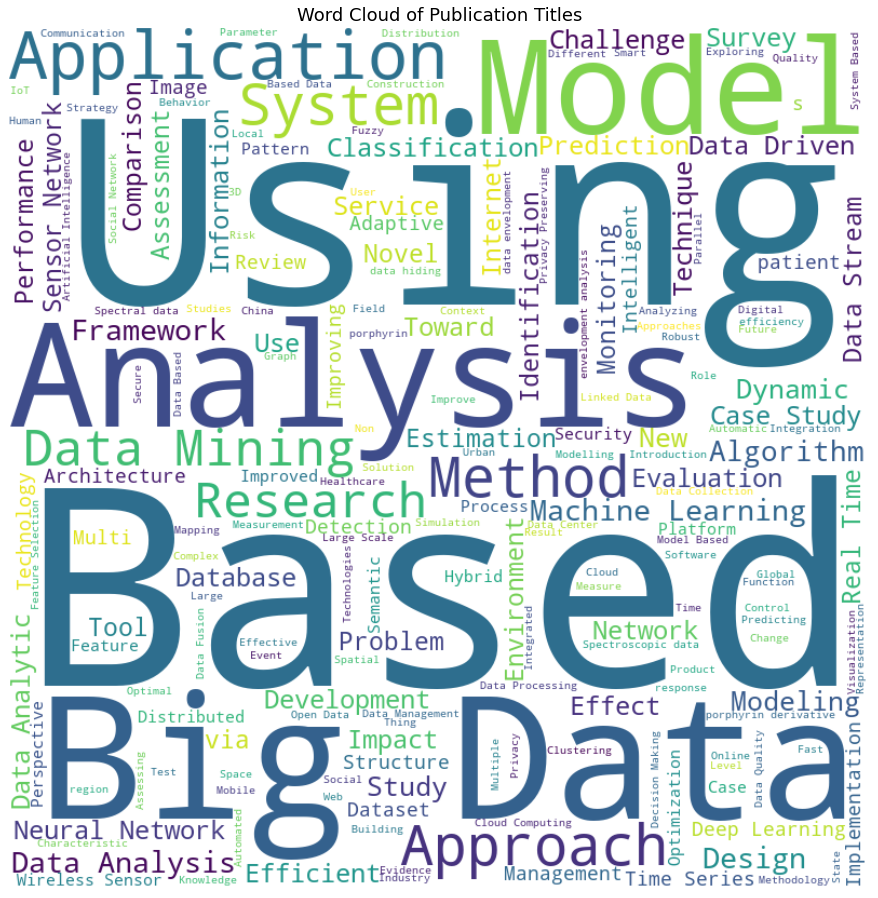

In [11]:
# To create a wordcloud of publication titles within our pool of recommendations

text = " ".join(i for i in corpus.title)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                min_font_size = 10, stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Publication Titles', fontsize=18)

plt.show()

#### Abstracts
This WordCloud is a snapshot of the words contained in the abstracts of the publications within our dataset.The words used are mostly related to the methodologies and descriptions of the publications. This is inline with the expectations on what to find inside an abstract.

Words like Algorithm, Big Data, Information are related to the domain of Data Science and is paired with words like Used, Model, Paper, Method as these are describing what has been done and what is the goal of the works.

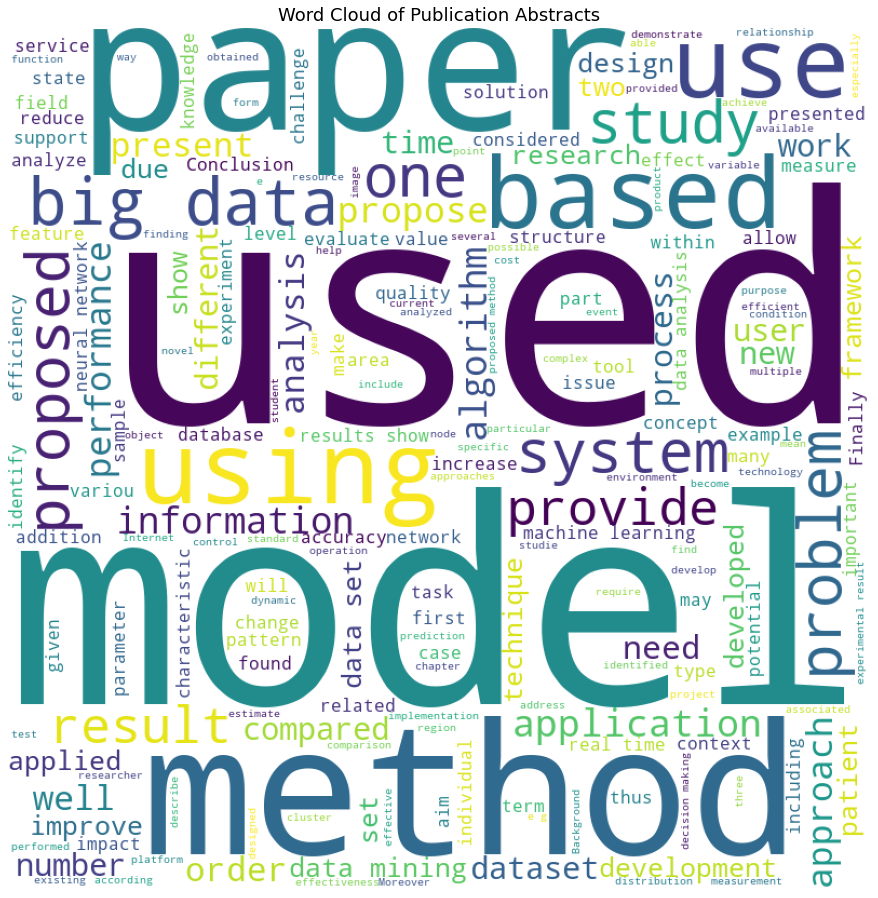

In [12]:
# To create a wordcloud of publication abstracts within our pool of recommendations

# get abstract corpus
corpus1 = corpus[['title', 'abstract', 'creators']]
corpus_abs = corpus['abstract']

# get all words of all abstracts into 1 string
string = ' '.join(corpus_abs)
    
# split string into words, remove special characters, lower case all
string_ = (re.sub('\W+','', string).lower().split(' '))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(string)
 
# plot the WordCloud image                      
plt.figure(figsize = (15, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Publication Abstracts', fontsize=18)
    
plt.show()

#### Authors

This word cloud is composed of authors with Data-Science-related publications in Springer. 

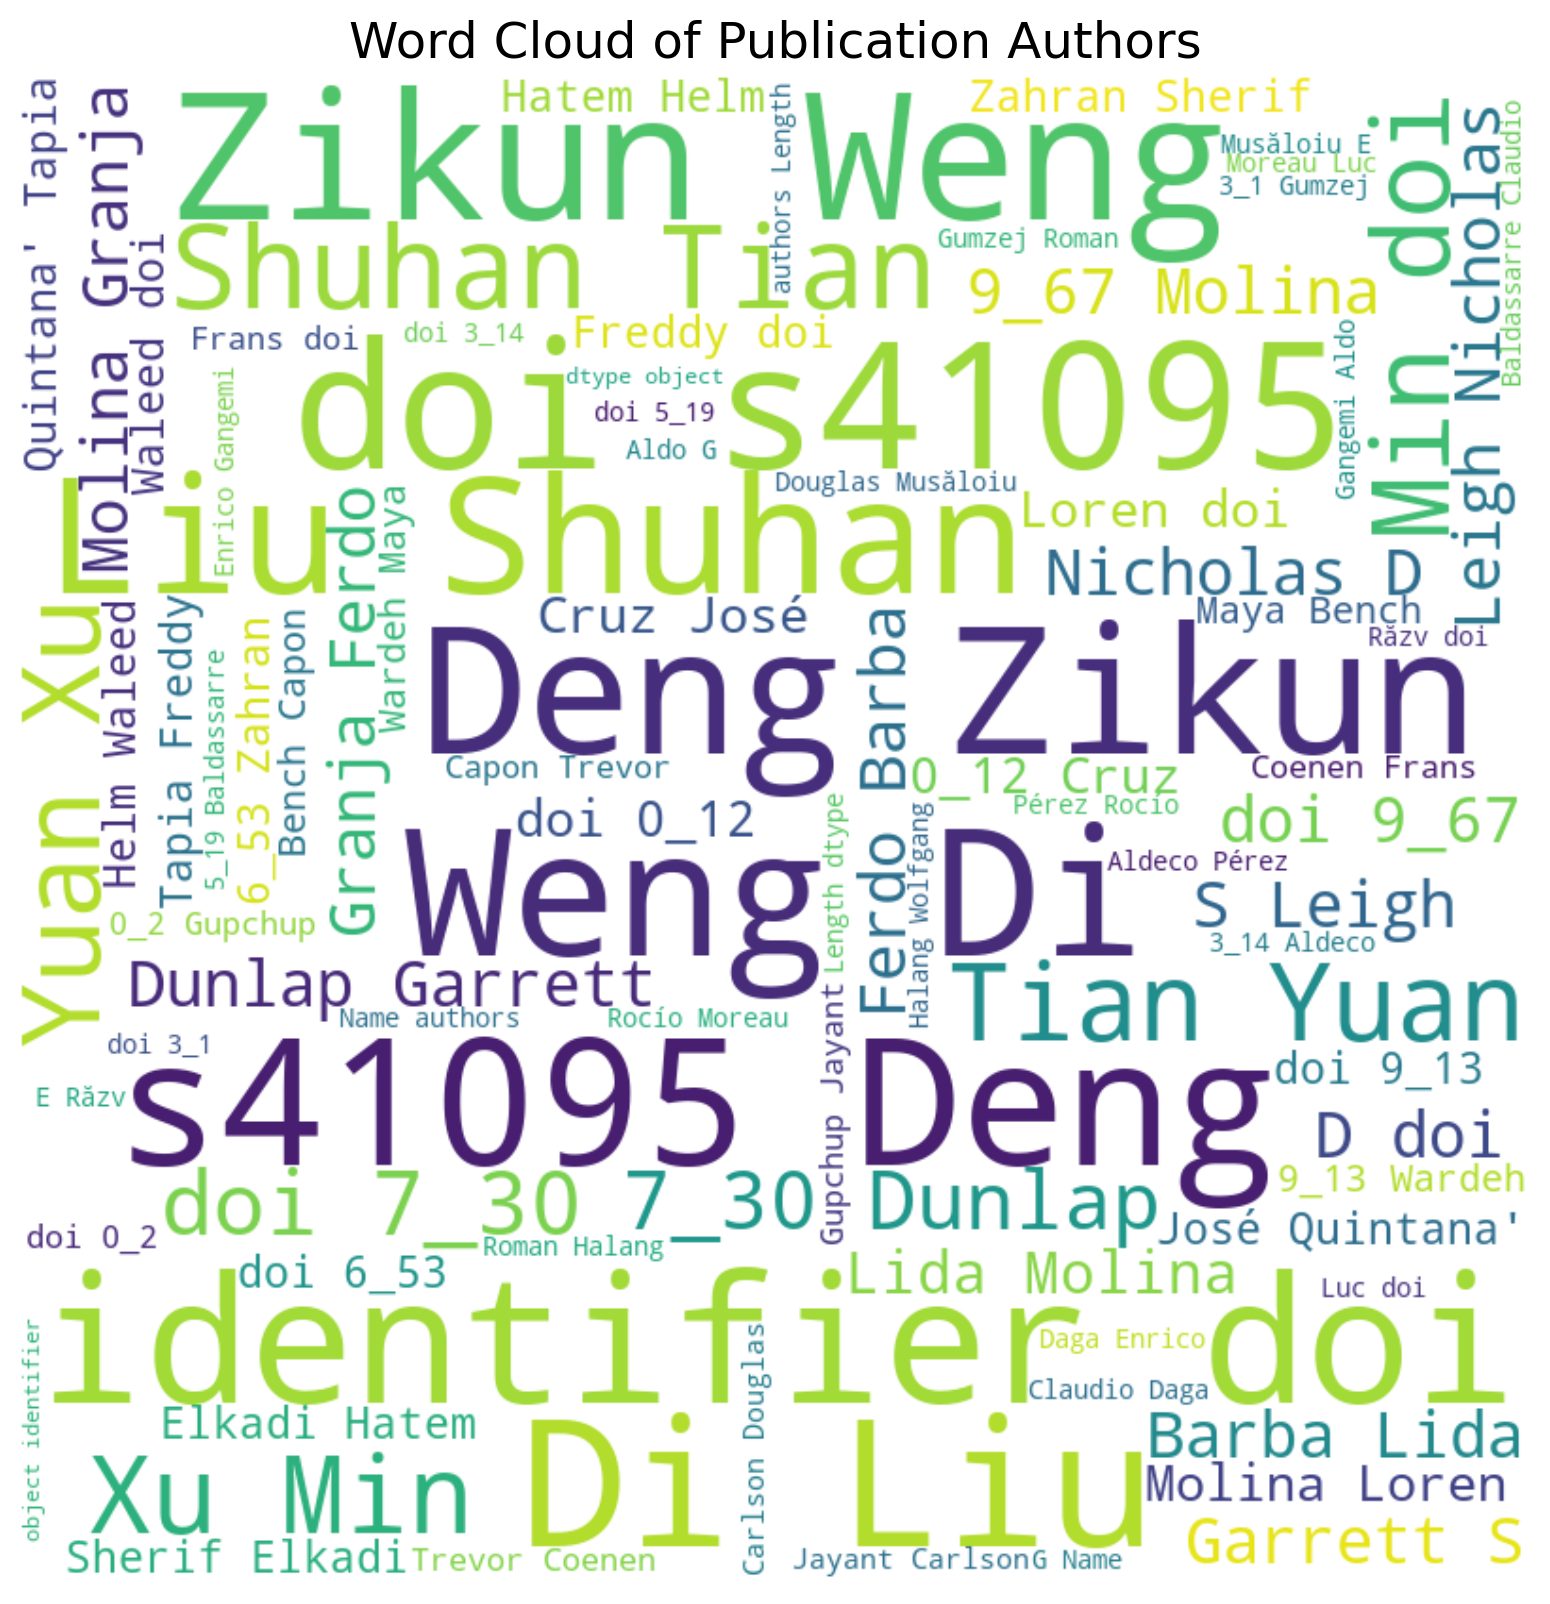

In [13]:
# To create a wordcloud of publication authors within our pool of recommendations

corpus['authors'] = corpus['creators'].apply(lambda x: pd.DataFrame(eval(str(x))).values)
corpus['authors'] = (corpus['authors'].astype(str).str.replace('[\[\],.\n]', '', regex=True)
                     .str.replace("^\'|\'$", '', regex=True)
                     .str.replace("\'\s+\'", ' ', regex=True))

corpus['authors'] = re.sub('nan','',str(corpus['authors']), flags=re.DOTALL)

text = " ".join(i for i in corpus.authors)
stopwords = set(STOPWORDS)

plt.rcParams['figure.dpi'] = 200
wordcloud = WordCloud(width = 800, height = 800, min_font_size = 10,
                      stopwords=stopwords, background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Publication Authors', fontsize=18)

plt.show()

To better highlight the ten most popular publication authors, please refer to the graph below. Here we see that Gupta, Dobhal, Predel, Chihara, Nakamura, Huttner, Villars, Cenzual, Steiner, Fischer, Baur, Cleiphas, Aeilko, Freemas have the most number contributions.

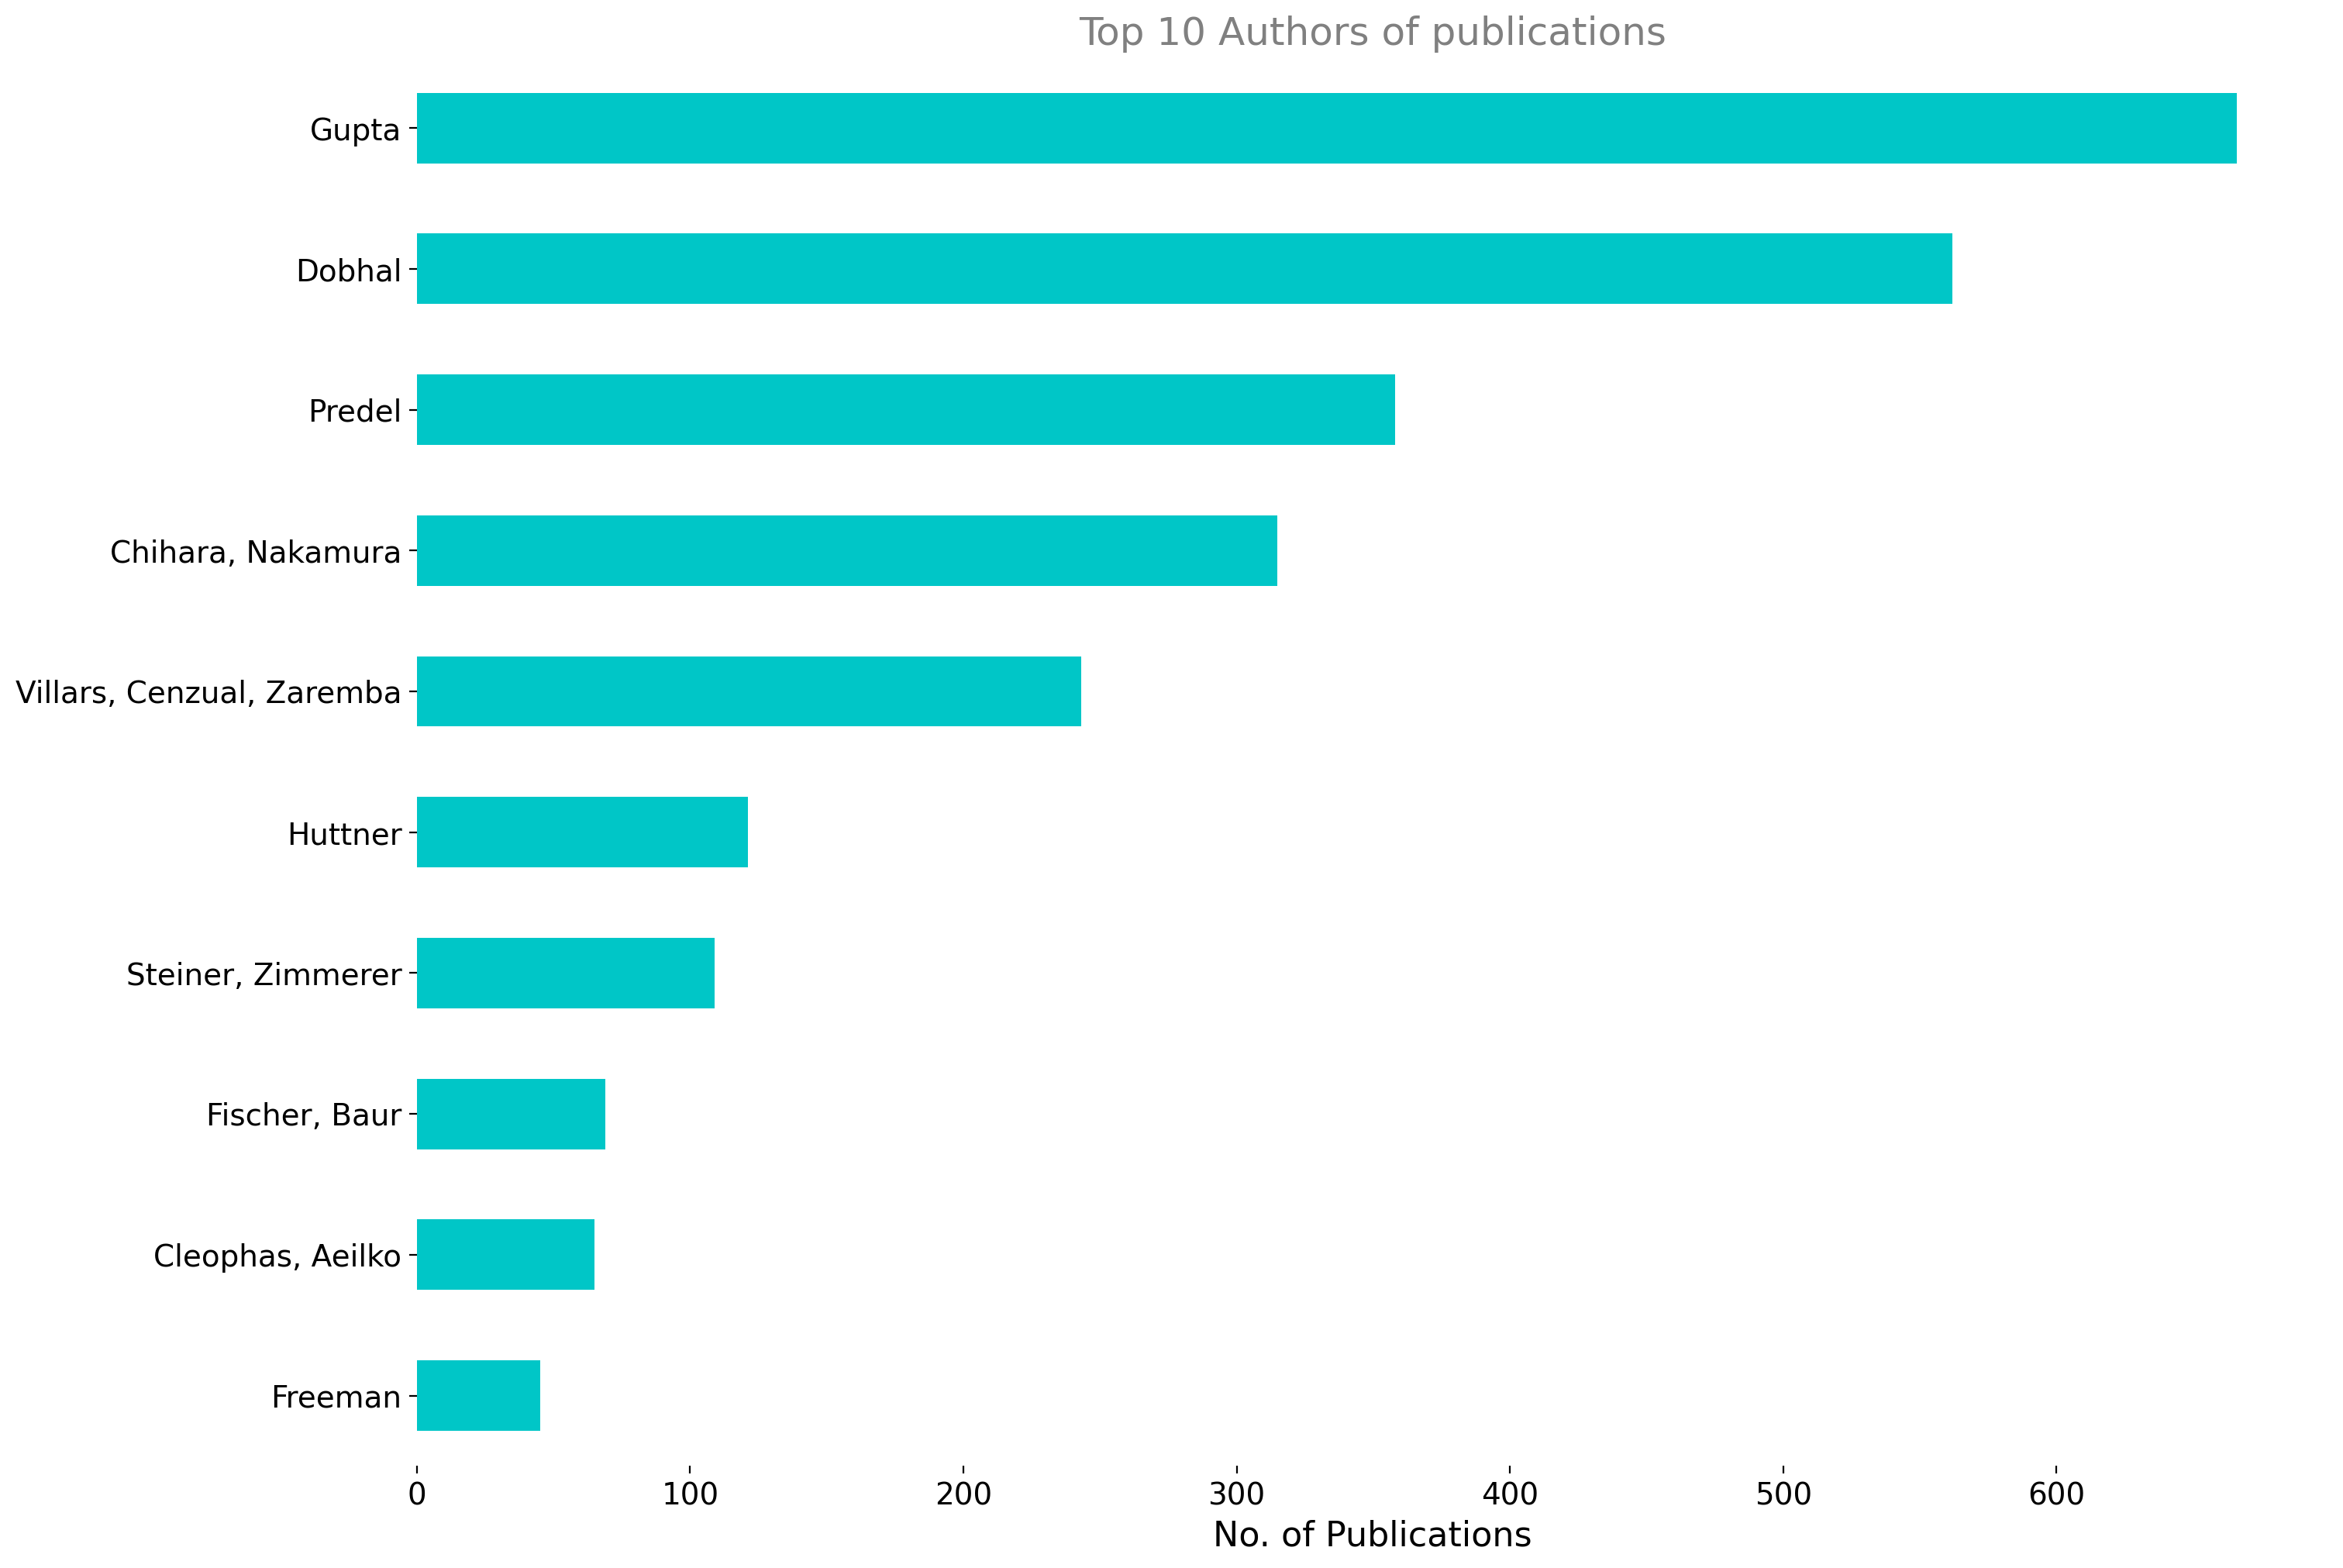

In [14]:
creator = corpus.creators.value_counts().to_frame().sort_values(by='creators', ascending=True).tail(10)

creator = creator.rename(index={"[{'creator': 'Gupta, A.'}]": "Gupta", "[{'creator': 'Dobhal, M. P.'}]": "Dobhal", 
                      "[{'creator': 'Predel, B.'}]": "Predel", "[{'creator': 'Chihara, H.'}, {'creator': 'Nakamura, N.'}]": "Chihara, Nakamura",
                      "[{'creator': 'Villars, P.'}, {'creator': 'Cenzual, K.'}, {'creator': 'Gladyshevskii, R.'}, {'creator': 'Shcherban, O.'}, {'creator': 'Dubenskyy, V.'}, {'creator': 'Kuprysyuk, V.'}, {'creator': 'Savysyuk, I.'}, {'creator': 'Zaremba, R.'}]": "Villars, Cenzual, Zaremba",
                     "[{'creator': 'Hüttner, W.'}]": "Huttner", "[{'creator': 'Steiner, G.'}, {'creator': 'Zimmerer, C.'}]": "Steiner, Zimmerer",
                     "[{'creator': 'Fischer, R. X.'}, {'creator': 'Baur, W. H.'}]": "Fischer, Baur",
                     "[{'creator': 'Cleophas, Ton J.'}, {'creator': 'Zwinderman, Aeilko H.'}]": "Cleophas, Aeilko",
                     "[{'creator': 'Freeman, Adam'}]": "Freeman"},
                      )

fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True)

ax.set_facecolor("white")
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

creator.plot(kind='barh', color='#00c6c7', ax=ax)

ax.get_legend().remove()

plt.title('Top 10 Authors of publications', fontsize=18, color='gray')
plt.xlabel("No. of Publications", fontsize=16)

plt.show()

## Publications Recommender Engine

In [15]:
class Vectorize:
    def __init__(self):
        self.mat_tfidf = None
        self.tfidf = None
        self.page = 0

    def tfid_vectorize(self, field, conn, m=None):
        """
        Pulls field specified from the springer_dump
        table and then creates its TF-IDF matrix
        """
        corpus = pd.read_sql(f'select {field} from springer_dump', conn)
        if field == 'creators':
            corpus['creators'] = corpus['creators'].apply(
                                lambda x: pd.DataFrame(eval(str(x))).values)
            corpus['creators'] = (corpus['creators'].astype(str).str.replace('[\[\],.\n]', '', regex=True)
                                  .str.replace("^\'|\'$", '', regex=True)
                                  .str.replace("\'\s+\'", ' ', regex=True))
        self.tfidf = TfidfVectorizer(stop_words='english', max_features=m)
        self.mat_tfidf = self.tfidf.fit_transform(corpus[field])
        return

    def get_similarities(self, word):
        """
        word - list but put only single entry
        
        Computes similarity score of word vs
        each item in recommendation pool
        """
        compare = self.tfidf.transform(word)
        cosine_similarities = linear_kernel(compare, self.mat_tfidf).flatten()
        args = (np.flip(np.argsort(cosine_similarities)))  # sort to descending
        args += 1  # rowid in database add 1 to adjust indexing
        return args

    def __process_creators__(self, c_list):
        """To format creator column in displayed results"""
        if c_list is not None and c_list != "":
            return " | ".join([i.get('creator') for i in ast.literal_eval(re.sub(r'\(|\)', '', c_list))])
        else:
            return None

    def make_clickable(self, val):
        """To format URLs in displayed results"""
        return '<a target="_blank" href="{}">{}</a>'.format(val, val)

    def search_dump(self, args, conn):
        """
        Main function that returns all matches
        in a formatted dataframe
        """
        p = self.page
        param = (",".join(str(n) for n in args[0+p:10+p]))
        pair = pd.read_sql(f"""SELECT title, creators, publicationname, url 
                               FROM springer_dump 
                               WHERE rowid IN ({param})""", conn)
        pair.url = pair.url.apply(lambda x: json.loads(
            x[1:-1].replace("'", "\"")).get('value'))
        pair.creators = pair.creators.apply(
            lambda x: self.__process_creators__(x))
        blankIndex = [''] * len(pair)
        pair.index = blankIndex
        pair = pair.style.format({'url': self.make_clickable})

        return pair

### Sample `title` query
Here are the results of a sample search that looks through the `title` column for keyword `Data Science`.

In [16]:
vectorizer_title = Vectorize()
vectorizer_title.tfid_vectorize('title', conn)
args = vectorizer_title.get_similarities(['Data Science'])
back_b  = widgets.Button(description='Previous')
next_b  = widgets.Button(description='Next')

vb = widgets.HBox([back_b, next_b])
df = vectorizer_title.search_dump(args, conn)
display(vb)
display(df)

def next_page(b, p):
    """
    To display multi page results
    and navigate through them using 
    a next button
    """
    vectorizer_title.page += p
    if vectorizer_title.page < 0:
        vectorizer_title.page = 0
    elif vectorizer_title.page > len(args):
        vectorizer_title.page = len(args) - 10
        
    df = vectorizer_title.search_dump(args, conn)
    clear_output(wait=True)
    display(vb)
    display(df)

next_b.on_click(functools.partial(next_page, p=10))
back_b.on_click(functools.partial(next_page, p=-10))

### Sample `abstract` query
Here are the results of a sample search that looks through the `abstract` column for keyword `Data Mining`.

In [17]:
vectorizer_abstract = Vectorize()
vectorizer_abstract.tfid_vectorize('abstract', conn)
args2 = vectorizer_abstract.get_similarities(['Data Mining'])
back_b2 = widgets.Button(description='Previous')
next_b2  = widgets.Button(description='Next')
vb2 = widgets.HBox([back_b2, next_b2])
df2 = vectorizer_abstract.search_dump(args2, conn)
display(vb2)
display(df2)

def next_page2(b, p):
    """
    To display multi page results
    and navigate through them using 
    a next button
    """
    vectorizer_abstract.page += p
    if vectorizer_abstract.page < 0:
        vectorizer_abstract.page = 0
    elif vectorizer_abstract.page > len(args2):
        vectorizer_abstract.page = len(args2) - 10
        
    df2 = vectorizer_abstract.search_dump(args2, conn)
    
    clear_output(wait=True)
    display(vb2)
    display(df2)

next_b2.on_click(functools.partial(next_page2, p=10))
back_b2.on_click(functools.partial(next_page2, p=-10))

### Sample `creator` query
Here are the results of a sample search that looks through the `creator` column for the name `Lundberg Alexander`.

In [18]:
vectorizer_authors = Vectorize()
vectorizer_authors.tfid_vectorize('creators', conn)
args3 = vectorizer_authors.get_similarities(['Lundberg Alexander'])
back_b3 = widgets.Button(description='Previous')
next_b3  = widgets.Button(description='Next')
vb3 = widgets.HBox([back_b3, next_b3])
df3 = vectorizer_authors.search_dump(args3, conn)
display(vb3)
display(df3)

def next_page3(b, p):
    """
    To display multi page results
    and navigate through them using 
    a next button
    """
    vectorizer_authors.page += p
    if vectorizer_authors.page < 0:
        vectorizer_authors.page = 0
    elif vectorizer_authors.page > len(args3):
        vectorizer_authors.page = len(args3) - 10
        
    df3 = vectorizer_authors.search_dump(args3, conn)
    
    clear_output(wait=True)
    display(vb3)
    display(df3)

next_b3.on_click(functools.partial(next_page3, p=10))
back_b3.on_click(functools.partial(next_page3, p=-10))

## Conclusion & Recommendations

The project has moderate complexity, and with the algorithm that we have built, we are able to return matches based on the similarity of scores computed from their cosine similarity. 

However, this is purely based on the words used and is dependent on the information found in the Abstract or Title field when we want to search for certain words or phrases. We may need to be more specific with the creator names if we want to get their works, as we are basing this on the count of the words provided from the cosine similarity of the words. 

And because the algorithm does not take semantics into consideration, the resulting project code base is light and can be implemented in a SME setting. These enterprises have small databases where they archive their documents and can easily implement it as an archive retrieval system for their internal documents without having to invest in a out-of-the-box document manager software.

Using publications scraped from the Springer API and word vectorization, we have successfully created a recommender system for publications using either the publication title, abstract, or creator as the query. The recommender system returns the title, creator, publication name, and URL of the closest publications to the query using cosine similarity as the measure of "closeness" or similarity. The code was further improved by building a "Next/Previous" widget around the search results. This is as close as we can get to building a recommender system UI/UX in Jupyter.

We only used the first 25,000 publications in Springer due to file size and runtime concerns, but the code should work for any number of publications. Scaling the database up would require the user to store the vectorization results in an SQL database or a pickle file. Even larger databases might require some form of stream processing to speed up queries.

Because we were unable to manually annotate the corpus, we were limited in the accuracy metrics we could present. This is also the reason why only one similarity measure was considered; without metrics, there was no other basis for comparisons. For the next future iterations, using manually annotated corpora would provide more insights about the performance of the different similarity measures.

Only four features of the metadata were vectorized, but the system can be easily extended to include all the features in the metadata. There is also an option to improve the code to allow multiple-feature queries or to implement post-search filtering based on any of the features. Finally, we note that the work makes use of the bag-of-words representation only, and hence we recommend that other text classification models like bigrams and semantic analysis be explored.

## References

[[1] Information retrieval. (2022, October 25). In Wikipedia. https://en.wikipedia.org/wiki/Information_retrieval](https://en.wikipedia.org/wiki/Information_retrieval) <br>

[[2] Recommender system. (2022, November 14). In Wikipedia. https://en.wikipedia.org/wiki/Recommender_system](https://en.wikipedia.org/wiki/Recommender_system) <br>

[[3] Dwivedi, R. (2022). What Are Recommendation Systems in Machine Learning? Analytics Steps. https://www.analyticssteps.com/blogs/what-are-recommendation-systems-machine-learning](https://www.analyticssteps.com/blogs/what-are-recommendation-systems-machine-learning) <br>

[[4] Sardar, A. (2017). Recommender System for Journal Articles using Opinion Mining and Semantics. (IJACSA) International Journal of Advanced Computer Science and Applications, Vol. 8, No. 12.](https://thesai.org/Downloads/Volume8No12/Paper_27-Recommender_System_for_Journal_Articles.pdf)